In [ ]:
!nvidia-smi

## 1) Installing libraries

In [1]:
!pip install transformers
!pip install datasets
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 26.6 MB/s 
     |████████████████████████████████| 120 kB 74.6 MB/s 
     |████████████████████████████████| 6.6 MB 53.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 29.5 MB/s 
     |████████████████████████████████| 212 kB 69.4 MB/s 
     |████████████████████████████████| 115 kB 65.1 MB/s 
     |████████████████████████████████| 127 kB 66.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 17.8 MB/s 
     |████████████████████████████████| 181 kB 48.4 MB/s 
     |████████████████

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset

## 2) Loading dataset (from HF)


In [ ]:
# enter your personal read token

In [3]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [4]:
from datasets import load_dataset

aggression_dataset = load_dataset("IIIT-L/total_code_mixed", use_auth_token=True)

print(aggression_dataset)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/IIIT-L___csv/IIIT-L--total_code_mixed-b73d4aed076f8a67/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 3976
    })
    test: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 498
    })
    validation: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 497
    })
})


In [5]:
train_ds = aggression_dataset['train']
train_ds

Dataset({
    features: ['Sentence', 'Label'],
    num_rows: 3976
})

## 3) Converting to dataframe

In [6]:
aggression_dataset.set_format(type='pandas')
train_df = aggression_dataset['train'][:]
valid_df = aggression_dataset['validation'][:]

train_df.head()

,Sentence,Label
0,We don't spend one hour and rush off from our ...,1
1,Shivani my classmate,0
2,True reviewerÃƒÂ°Ã…Â¸Ã¢â€žÂ¢Ã‚Â,0
3,Royal C***yas Bangalore ÃƒÂ°Ã…Â¸Ã‹Å“Ã¢â‚¬Å¡ÃƒÂ...,2
4,*PURE DESH ME AFRA TAFRI KA MAHOOL HAI...INDIA...,2


In [7]:
test_df = aggression_dataset['test'][:]

In [8]:
train_df['Label'].value_counts()

0    2137
1    1086
2     753
Name: Label, dtype: int64

In [ ]:
# 3976
# NAG-CAG-OAG (0-1-2) = 0.54-0.27-0.19

Seeing Distribution

In [9]:
disb_df = train_df.copy(deep=True)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


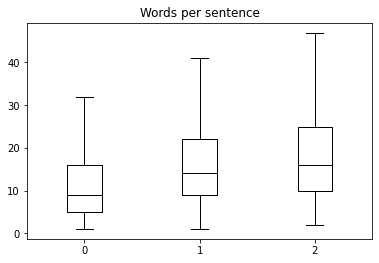

In [10]:
disb_df['Words per sentence'] = disb_df['Sentence'].str.split().apply(len)
disb_df.boxplot('Words per sentence', by='Label', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## 4) Tokenizing

In [11]:
from transformers import AutoTokenizer

In [12]:
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [13]:
tokenizer.vocab_size

30522

In [14]:
train_texts = list(train_df['Sentence'])
train_labels = list(train_df['Label'])

In [15]:
valid_texts = list(valid_df['Sentence'])
valid_labels = list(valid_df['Label'])

## 5) Encoding train-valid

In [16]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True)

In [17]:
import torch

class AggressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [18]:
train_dataset = AggressionDataset(train_encodings, train_labels)
valid_dataset = AggressionDataset(valid_encodings, valid_labels)

## 6) Setting classification model and evaluation metrics

In [19]:
import torch

In [ ]:
# Use in case of CUDA memory error

# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [20]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def model_init():
    model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))
    return model

cuda


In [21]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

## 7) Fine-tuning, visualizing training, saving model to HF  

In [22]:
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [23]:
%env WANDB_PROJECT = aggression_detection

env: WANDB_PROJECT=aggression_detection


In [24]:
from transformers import Trainer, TrainingArguments

In [25]:
# Defining hyperparameters
eval_batch_size = 16
logging_steps = len(train_texts) // eval_batch_size
model_name = f"{model_ckpt}-finetuned-code-mixed-DS"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=4,
                                  learning_rate=4.735606601498067e-05,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  weight_decay=0.11295513488219684,
                                  evaluation_strategy='steps',
                                  save_strategy='steps',
                                  max_steps=-1,
                                  warmup_ratio=0.0,
                                  seed=43,
                                  data_seed=4,
                                  metric_for_best_model="eval_f1",
                                  greater_is_better=True,
                                  load_best_model_at_end=True, 
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=logging_steps,
                                  log_level='info', 
                                  report_to="wandb", 
                                  run_name="bert-base-code-mixed-DS",
                                  push_to_hub=True)

In [ ]:
# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [26]:
from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    # device = torch.device('cuda')
    # inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.17, 0.27, 0.56]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [27]:
from transformers import EarlyStoppingCallback

In [28]:
# enter your personal write token here

from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [29]:
trainer = CustomTrainer(model_init=model_init,
                        args=training_args,
                        compute_metrics = compute_metrics,
                        train_dataset = train_dataset,
                        eval_dataset = valid_dataset,
                        tokenizer = tokenizer, 
                        callbacks = [EarlyStoppingCallback(early_stopping_patience = 2, early_stopping_threshold=0.0001)]
)

trainer.train()

# post-training analysis, testing, other logged code
wandb.finish()

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_

storing https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
creating metadata file for /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.we

wandb: Currently logged in as: sky-s-the-limit. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
248,0.899300,0.783415,0.653924,0.604042,0.622648,0.600644
496,0.611000,0.770874,0.692153,0.631445,0.644715,0.634932
744,0.341400,1.220930,0.742455,0.712611,0.657631,0.667748
992,0.174700,1.242839,0.726358,0.670821,0.663298,0.665433


***** Running Evaluation *****
  Num examples = 497
  Batch size = 16
Saving model checkpoint to bert-base-uncased-finetuned-code-mixed-DS/checkpoint-248
Configuration saved in bert-base-uncased-finetuned-code-mixed-DS/checkpoint-248/config.json
Model weights saved in bert-base-uncased-finetuned-code-mixed-DS/checkpoint-248/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-code-mixed-DS/checkpoint-248/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-code-mixed-DS/checkpoint-248/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-finetuned-code-mixed-DS/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-code-mixed-DS/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 497
  Batch size = 16
Saving model checkpoint to bert-base-uncased-finetuned-code-mixed-DS/checkpoint-496
Configuration saved in bert-base-uncased-finetuned-code-mixed-DS/checkpoint-496/config.json


eval/accuracy,▁▄█▇
eval/f1,▁▅██
eval/loss,▁▁██
eval/precision,▁▃█▅
eval/recall,▁▅▇█
eval/runtime,▁█▄█
eval/samples_per_second,█▁▅▁
eval/steps_per_second,█▁▅▁
train/epoch,▁▁▃▃▆▆███
train/global_step,▁▁▃▃▆▆███
train/learning_rate,█▆▃▁


In [30]:
trainer.push_to_hub()

Saving model checkpoint to bert-base-uncased-finetuned-code-mixed-DS
Configuration saved in bert-base-uncased-finetuned-code-mixed-DS/config.json
Model weights saved in bert-base-uncased-finetuned-code-mixed-DS/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-code-mixed-DS/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-code-mixed-DS/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/418M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/SkyR/bert-base-uncased-finetuned-code-mixed-DS
   e590357..93a6a22  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/SkyR/bert-base-uncased-finetuned-code-mixed-DS
   e590357..93a6a22  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.7263581488933601}, {'name': 'Precision', 'type': 'precision', 'value': 0.6708212731604544}, {'name': 'Recall', 'type': 'recall', 'value': 0.6632977160901814}, {'name': 'F1', 'type': 'f1', 'value': 0.6654333692045556}]}
To https://huggingface.co/SkyR/bert-base-uncased-finetuned-code-mixed-DS
   93a6a22..ecfd6e4  main -> main

   93a6a22..ecfd6e4  main -> main



'https://huggingface.co/SkyR/bert-base-uncased-finetuned-code-mixed-DS/commit/93a6a2212df4d758cb2f2f1e977a4bb66da43d78'

## 8) Predictions and Results

In [31]:
test_texts = list(test_df['Sentence'])
test_labels = list(test_df['Label'])

In [32]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [33]:
test_dataset = AggressionDataset(test_encodings, test_labels)

In [34]:
preds_output_test = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 498
  Batch size = 16


In [35]:
preds_output_test.metrics

{'test_loss': 1.2734713554382324,
 'test_accuracy': 0.7228915662650602,
 'test_precision': 0.6826087394382508,
 'test_recall': 0.6425779425774755,
 'test_f1': 0.6522151296987967,
 'test_runtime': 12.0874,
 'test_samples_per_second': 41.2,
 'test_steps_per_second': 2.647}

In [36]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

In [37]:
y_valid_test = np.array(test_dataset.labels)

In [38]:
map_dt = {0:'NAG', 1:'CAG', 2:'OAG'}

In [39]:
print(classification_report(y_valid_test, y_preds_test, target_names=list(map_dt.values())))

              precision    recall  f1-score   support

         NAG       0.82      0.87      0.84       268
         CAG       0.57      0.64      0.60       136
         OAG       0.66      0.41      0.51        94

    accuracy                           0.72       498
   macro avg       0.68      0.64      0.65       498
weighted avg       0.72      0.72      0.72       498



In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : map_dt[x], y_valid_test)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : map_dt[x], y_preds_test)
y_preds_trying = list(y_preds_trying)

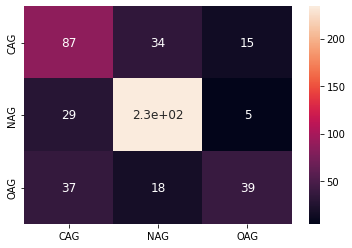

In [41]:
cm_labels = np.unique(y_valid_trying)
cm_array = confusion_matrix(y_valid_trying, y_preds_trying)
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12}) 